In [408]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from UtilityGraph import *
from Defence import *
from Corruption import *
from UtilityMLP import *
import random
from scipy.stats import *
import copy
import seaborn as sns
from Test import *
import math

In [409]:
Seed = 2001  # for reproducibility
random.seed(Seed)
np.random.seed(Seed) 
torch.manual_seed(Seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(Seed)
    torch.cuda.manual_seed_all(Seed)


In [410]:
# Graph
required_probability=0.9999
num_nodes, G,A,pos,r_c=build_random_graph(40,required_probability,fix_num_nodes=True)
print("num_nodes:",num_nodes)

percentageCorrupt = 1/num_nodes   #Percentage of corrupt clients




var = 30                  # Standard deviation for Gaussian noise
mean = 1                    # Mean for Gaussian noise
Target = np.random.randint(1, num_nodes) # Target client for copycat attack
scale = 1
typeAttack = 0              # 0: No attack, 1: Gaussian noise, 2: Copycat attack, 3: Gaussian addative noise attack, 4: LIE attack

corrupt = True              #If True, corrupt clients are included
CorruptClients = CorruptGeneration(percentageCorrupt, corrupt, num_nodes) #Selection of Corrupt Clients
CorruptClients = np.array(CorruptClients, dtype=int)

lying_nodes = np.where(CorruptClients == 1)[0]
true_nodes = [i for i in range(num_nodes) if i not in lying_nodes]


# Data
Data = np.zeros([num_nodes,1])
RealMean = 25
RealVar = 500
for i in range(num_nodes):
    Data[i] = np.random.normal(RealMean, np.sqrt(RealVar))

Control = Data.copy()



num_nodes: 40
IteNumber of Corrupt nodesration 1, Corrupt nodes: [6]


In [411]:
def normpdf(x, mn, var):
    denom = (2 * np.pi * var)**0.5 
    num = np.exp(-((x - mn)**2) / (2 * var + 1e-6)) 
    return num / (denom + 1e-6)

In [412]:
# Define the normal probability density function
def shownormpdf(mn, var):
    # Step 2: Create x values (input range)
    x = np.linspace(-10, 20, 500)  # Adjust the range to better visualize the Gaussian

    # Step 3: Compute y values (apply the function)
    y = normpdf(x,mn,var)

    # Step 4: Plot the function
    plt.plot(x, y, label='Normal PDF (mean={mn}, variance={var})'.format(mn=mn, var=var))

    # Step 5: Customize the plot
    plt.title("Plot of Normal Probability Density Function")  # Add title
    plt.xlabel("x")  # Label x-axis
    plt.ylabel("f(x)")  # Label y-axis
    plt.axhline(0, color='black', linewidth=0.5)  # Add x-axis line
    plt.axvline(0, color='black', linewidth=0.5)  # Add y-axis line
    plt.grid(True)  # Add grid
    plt.legend()

    # Step 6: Show the plot
    plt.show()
    return 0


In [413]:
def nodeSelection(max_iters, num_nodes):
    #Selecting nodes for its turn
    nodes_list = []
    for i in range(max_iters):
        nodes_list.append(np.random.randint(0,num_nodes))
    return nodes_list

In [414]:
def check(Rec_Data, Rec_Data_Prev , i, Stepsize, num_nodes, count):
    u = np.zeros((num_nodes, num_nodes))
    Capital_U = np.zeros((num_nodes, num_nodes))
    if count == 0:
        for j in G.neighbors(i):
            u[i][j] = (Rec_Data[j][i] - Rec_Data_Prev[j][i])/(1)
    else:
        for j in G.neighbors(i):
            u[i][j] = (Rec_Data[j][i] - Rec_Data_Prev[j][i])/(Stepsize/count)

    list_for_median = []
    for j in G.neighbors(i):
        for k in G.neighbors(j):
            if k == j:
                continue  # Skip if it's the same neighbor
            list_for_median.append(u[i][k])
        Current_Median = np.median(list_for_median)
        Capital_U[i][j] = abs(u[i][j] - Current_Median)

    return Capital_U

In [415]:
def PDMM(
    Data, G, avg_temp, tolerance, c, max_iters, Control,
    averaging, Timer, K_decision, rejection_threshold
):
    """
    PDMM with attacker detection/avoidance mechanics.

    :param Data:           Numpy array of node data (num_nodes x 1).
    :param G:              Graph (e.g., networkx Graph).
    :param avg_temp:       Reference average (scalar or array).
    :param tolerance:      Convergence tolerance for x updates.
    :param c:              Step-size or penalty parameter in PDMM.
    :param mu:             Step-size in Check function.
    :param max_iters:      Maximum number of iterations.
    :param Control:        Not currently used; copy of Data (?)
    :param averaging:      Averaging parameter for z update (alpha).
    :param Timer:          Iterations between short-term checks.
    :param K_decision:     Iterations between longer-term acceptance/rejection decisions.
    :param rejection_threshold: Threshold factor for attacker detection.

    :return:
        Error             -- Numpy array of norm differences (over true nodes).
        count             -- Number of iterations performed.
        dual_history      -- History of dual updates at each iteration.
        x_history         -- History of x updates at each iteration.
        z_history         -- History of z updates at each iteration.
        dual_calc_history -- History of calc_dual at each iteration.
        x_calc_history    -- History of calc_x at each iteration.
    """

    # Reproducibility seeds
    Seed = 2001
    random.seed(Seed)
    np.random.seed(Seed)
    torch.manual_seed(Seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(Seed)
        torch.cuda.manual_seed_all(Seed)

    num_nodes = G.number_of_nodes()

    x = np.zeros([num_nodes, 1])
    converged = False
    Error = np.array([])
    mean_estimate = np.zeros([num_nodes, 1])
    var_estimate = np.zeros([num_nodes, 1])

    # Initialise A_ij
    A_ij = calc_incidence_nested(G)

    # Initialise z_ij, y_ij, dual, etc.
    z = np.zeros((num_nodes, num_nodes))
    y = np.zeros((num_nodes, num_nodes))
    dual = np.zeros((num_nodes, num_nodes))
    calc_dual = np.zeros((num_nodes, num_nodes))
    calc_x = np.zeros([num_nodes, 1])
    temp_y = np.zeros((num_nodes, num_nodes))

    sum_check = np.zeros((num_nodes, num_nodes))
    mask = np.ones((num_nodes, num_nodes), dtype=bool)
    immediate_reject = np.zeros((num_nodes, num_nodes), dtype=bool)
    reject_count = np.zeros((num_nodes, num_nodes), dtype=int)

    dual_history = []
    dual_calc_history = []
    y_history = []
    x_history = []
    x_calc_history = []
    z_history = []

    count = 0
    Track = 0
    z_values = np.zeros_like(z)

    dual_calc_history.append(calc_dual.copy())

    while (not converged) and (count < max_iters):

        # 1) Update x
        x_new = np.zeros_like(x)
        for i in range(num_nodes):
            numerator_i = Data[i].copy()
            for j in G.neighbors(i):
                if mask[i][j]:
                    numerator_i += -A_ij[i][j] * z[i][j]
            x_new[i] = numerator_i / (1 + c * G.degree(i))
        x = x_new

        x_history.append(x.copy())  # Store x for this iteration

        # 2) Update dual
        for i in range(num_nodes):
            for j in G.neighbors(i):
                if mask[i][j]:
                    dual[i][j] = z[i][j] + c * (x[i] * A_ij[i][j])
        dual_history.append(dual.copy())  # Store dual for this iteration

        # 3) Update y
        for i in range(num_nodes):
            for j in G.neighbors(i):
                if mask[i][j]:
                    temp_y[i][j] = y[i][j]
                    y[i][j] = 2 * dual[i][j] - z[i][j]
        y_history.append(y.copy())  # Store y for this iteration

        # "Transmit" y and compute calc_dual
        for i in range(num_nodes):
            for j in G.neighbors(i):
                calc_dual[j][i] = (y[j][i] + temp_y[i][j]) / 2

        # Periodic check every other iteration
        if count % 1 == 0:
            for i in range(num_nodes):
                sum_check += check(calc_dual, dual_calc_history[count], i, c, num_nodes, count)
                # for j in G.neighbors(i):
                #     print(f"sum_check: {sum_check[i][j] *2 / Timer} for node {i} and {j}  calc_dual: {calc_dual[j][i]}")
                # sum_check += check(abs(y), abs(y_history[count]) , i, c, num_nodes)

        # Compare sum_check to threshold every Timer steps
        if count % Timer == 0 and count != 0:
            for i in range(num_nodes):
                for j in G.neighbors(i):
                    if ((sum_check[i][j] * 2) / Timer) > (rejection_threshold * np.sqrt(G.degree(i))):
                        print(f"sum_check: {sum_check[i][j] *2 / Timer}, threshold: {rejection_threshold * np.sqrt(num_nodes)} for node {i} and {j}")
                    # print(f"sum_check: {sum_check[i][j] *2 / Timer}, threshold: {rejection_threshold * np.sqrt(num_nodes)} for node {i} and {j}")
                    # if ((sum_check[i][j] * 2) / Timer) > (rejection_threshold * np.sqrt(num_nodes)):
                        # Increase rejection count: mark j as rejected for this decision moment
                        print(f"""Node {i} rejected node {j}""")
                        reject_count[i][j] += 1
        sum_check = np.zeros((num_nodes, num_nodes))

        Track += 1

        # Allow re-checking all neighbors every K_decision steps
        if Track % K_decision == 0:
            for i in range(num_nodes):
                for j in G.neighbors(i):
                    mask[i][j] = True
                    # reject_count[i][j] = 0

        # Long-term decision if neighbor is repeatedly rejected
        if Track % K_decision == 0:
            for i in range(num_nodes):
                for j in G.neighbors(i):
                    rejection_ratio = reject_count[i][j] / K_decision
                    if rejection_ratio > 0.5:
                        mask[i][j] = False
                        print(f"Node {i} rejected node {j}")
                    else:
                        mask[i][j] = True
                    # Reset counters


        # 4) Update z
        for i in range(num_nodes):
            for j in G.neighbors(i):
                calc_x[j] = (calc_dual[j][i] - temp_y[i][j]) / (c * A_ij[i][j] * -1)
                if (not mask[i][j]):
                    # If j is rejected, set z[i][j] to 0
                    z[i][j] = 0
                    # z[i][j] =  z[i][j]
                else:
                    # Otherwise, update z[i][j] normally (averaging)
                    z[i][j] = (1 - averaging) * z[i][j] + averaging * y[j][i]

        dual_calc_history.append(calc_dual.copy())  # Store calc_dual for this iteration
        x_calc_history.append(calc_x.copy())        # Store calc_x for this iteration
        z_history.append(z.copy())                  # Store z for this iteration

        # Compute error based on true_nodes (assuming it is defined outside)
        diff = x[true_nodes] - avg_temp
        norm_diff = np.linalg.norm(diff)
        Error = np.append(Error, norm_diff)

        count += 1
        if norm_diff < tolerance:
            print(f"Iteration {count}, Norm of difference: {norm_diff:.8f}")
            converged = True

        # for i in range(num_nodes):
        #     mean_sum = 0
        #     for j in G.neighbors(i):
        #         mean_sum += dual[i][j]
        #     mean_estimate[i] = mean_sum / (G.degree(i))

        # for i in range(num_nodes):
        #     var_sum = 0
        #     for j in G.neighbors(i):
        #         var_sum += (dual[i][j] - mean_estimate[i]) ** 2
        #     var_estimate[i] = var_sum / (G.degree(i))

    print(f"x = {x}")

    return (
        Error, count, dual_history, x_history, z_history,
        dual_calc_history, x_calc_history
)


In [416]:
def ADMM(Data, G, avg_temp, tolerance, rho, max_iters, Control):
    Seed = 2001  # for reproducibility
    random.seed(Seed)
    np.random.seed(Seed) 
    torch.manual_seed(Seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(Seed)
        torch.cuda.manual_seed_all(Seed)

    num_nodes = G.number_of_nodes()
    x = np.zeros((num_nodes,1))
    z = np.zeros((num_nodes, num_nodes))
    y = np.zeros((num_nodes, num_nodes))
    y_history = [] 
    x_history = [] 
    z_history = []
    Error = np.array([])
    count = 0
    converged = False

    while not converged and count < max_iters:
        # Synchronous update for x
        x_new = np.zeros_like(x)
        for i in range(num_nodes):
            neighbors_i = list(G.neighbors(i))
            numerator_i = Data[i].copy()
            for nbr in neighbors_i:
                numerator_i += rho * z[i][nbr] - y[i][nbr]
            x_new[i] = numerator_i / (1 + rho * G.degree(i))
        x = x_new
        x_history.append(x.copy())  # Store dual values for this iteration

        # Synchronous update for z and y
        for i in range(num_nodes):
            for j in G.neighbors(i):
                z_val = 0.5 * (x[i] + x[j])
                z[i][j] = z_val

        z_history.append(z.copy())  # Store dual values for this iteration


        for i in range(num_nodes):
            for j in G.neighbors(i):
                y[i][j] = y[i][j] + rho * (x[i] - z[i][j])


        y_history.append(y.copy())  # Store dual values for this iteration
        
        diff = x - avg_temp
        norm_diff = np.linalg.norm(diff)
        Error = np.append(Error, norm_diff)
        count += 1
        if norm_diff < tolerance:
            print(f'Iteration {count}, Norm of difference: {norm_diff:.8f}')
            converged = True

    print(f"x = {x}")
    return Error, count, y_history, x_history, z_history


In [417]:
def main():
    calc_mean = 0
    max_iters=500             #PDMM max iterations
    averaging = 1         #Averaging alpha
    tolerance=-1        #PDMM tolerance
    c=0.4                     #PDMM c
    
    Timer = 5               #Timer for check function 

    K_decision = 2

    nodes_list = nodeSelection(max_iters, num_nodes)
    avg_temp = np.mean(Data)

    # This checks if lying_nodes is not empty
    for node in lying_nodes:
        Data[node] = 10000


    print(avg_temp)
    Error = []
    Error_A = []

    threshold_values = [3]
    # threshold_values = [1.7337242752546444e-12]
    for rejection_threshold in threshold_values:
        Error, Transmission,dual_P, x_P, z_P,dual_calc_history, x_calc_history = PDMM(Data, G, avg_temp, tolerance, c, max_iters,Control,averaging,Timer,K_decision,rejection_threshold)
    
    # Error_A, Transmission,dual_A, x_A, z_A = ADMM(Data, G, avg_temp, tolerance, c, max_iters,Control)
    # print(f"Dual average PDMM = {np.mean(dual_P)} Dual Average ADMM = {np.mean(dual_A)}")  
    # min_iterations = min(len(dual_P), len(dual_A))
    # differences = []
    # differences_x = []
    # differences_z = []
    # for i in range(min_iterations):
    #     # Compute the difference (e.g., Frobenius norm) for iteration i
    #     diff = np.linalg.norm(dual_P[i] - dual_A[i], 'fro')
    #     diff_x = np.linalg.norm(x_P[i] - x_A[i], 'fro')
    #     diff_z = np.linalg.norm(z_P[i] - z_A[i], 'fro')

    #     differences.append(diff)
    #     differences_x.append(diff_x)    
    #     differences_z.append(diff_z)
    #     print(f"Iteration {i + 1}: Difference = {diff:.8f}")
    #     print(f"Iteration {i + 1}: Difference x = {diff_x:.8f}")
    #     print(f"Iteration {i + 1}: Difference z = {diff_z:.8f}")

    # plt.plot(range(1, len(differences) + 1), differences, marker='o')
    # plt.xlabel("Iteration")
    # plt.ylabel("Difference (Frobenius norm)")
    # plt.title("Comparison of Dual Histories")
    # plt.grid(True)
    # plt.show()
    # plt.figure(figsize=(10, 4))

    # plt.plot(range(1, len(differences_x) + 1), differences_x, marker='o')
    # plt.xlabel("Iteration")
    # plt.ylabel("Difference (Frobenius norm)")
    # plt.title("Comparison of x Histories")
    # plt.grid(True)
    # plt.show()
    # plt.figure(figsize=(10, 4))

    
    # plt.plot(range(1, len(differences_z) + 1), differences_z, marker='o')
    # plt.xlabel("Iteration")
    # plt.ylabel("Difference (Frobenius norm)")
    # plt.title("Comparison of z Histories")
    # plt.grid(True)
    # plt.show()
    # plt.figure(figsize=(10, 4))

    # Plot  error
        plt.plot(range(len(Error)), Error, label='PDMM Convergence')
        # plt.plot(range(len(Error_A)), Error_A, label='ADMM Convergence')
        plt.yscale('log')
        plt.title('Error Convergence Over Iteration Rounds')
        plt.xlabel('Iteration Round')
        plt.ylabel('Norm Error')
        plt.legend()
        plt.show()
        plt.figure(figsize=(10, 4))

24.51371595476399
sum_check: 104.98813659558081, threshold: 18.973665961010276 for node 0 and 4
Node 0 rejected node 4
sum_check: 115.57317067458655, threshold: 18.973665961010276 for node 0 and 15
Node 0 rejected node 15
sum_check: 72.86084858279906, threshold: 18.973665961010276 for node 0 and 19
Node 0 rejected node 19
sum_check: 207.8842032848749, threshold: 18.973665961010276 for node 0 and 20
Node 0 rejected node 20
sum_check: 98.83865714407875, threshold: 18.973665961010276 for node 0 and 22
Node 0 rejected node 22
sum_check: 115.66740944809594, threshold: 18.973665961010276 for node 0 and 29
Node 0 rejected node 29
sum_check: 244.32853727609796, threshold: 18.973665961010276 for node 0 and 34
Node 0 rejected node 34
sum_check: 24.08853817417757, threshold: 18.973665961010276 for node 1 and 12
Node 1 rejected node 12
sum_check: 25.599947831912075, threshold: 18.973665961010276 for node 1 and 33
Node 1 rejected node 33
sum_check: 84.7527186353642, threshold: 18.973665961010276 fo

C:\Users\za_re\AppData\Local\Temp\ipykernel_13276\3424944178.py:95: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dual[i][j] = z[i][j] + c * (x[i] * A_ij[i][j])


sum_check: 1980.4037845229814, threshold: 18.973665961010276 for node 3 and 8
Node 3 rejected node 8
sum_check: 117.25352057633643, threshold: 18.973665961010276 for node 3 and 19
Node 3 rejected node 19
sum_check: 180.8924422191937, threshold: 18.973665961010276 for node 4 and 34
Node 4 rejected node 34
sum_check: 951.1408702725994, threshold: 18.973665961010276 for node 5 and 38
Node 5 rejected node 38
sum_check: 1125.3301444706535, threshold: 18.973665961010276 for node 5 and 39
Node 5 rejected node 39
sum_check: 1306.4969003991307, threshold: 18.973665961010276 for node 8 and 3
Node 8 rejected node 3
sum_check: 180.89244221919327, threshold: 18.973665961010276 for node 14 and 34
Node 14 rejected node 34
sum_check: 116.03342027160231, threshold: 18.973665961010276 for node 17 and 18
Node 17 rejected node 18
sum_check: 116.30984107480215, threshold: 18.973665961010276 for node 17 and 21
Node 17 rejected node 21
sum_check: 97.8547951713613, threshold: 18.973665961010276 for node 17 an

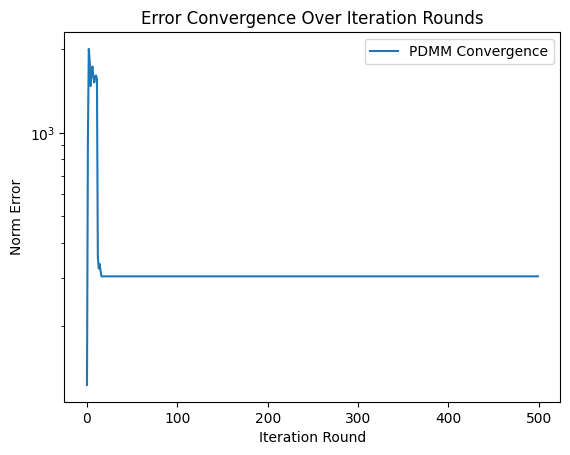

<Figure size 1000x400 with 0 Axes>

In [418]:
if __name__ == '__main__':
    main()